# Intoduction

This project focuses on object detection using **YOLOv10**, a state-of-the-art deep learning model known for its speed and accuracy.   

The goal was to detect and localize  license plates  in both images and videos. The model was trained on a **custom dataset** - car-plate-detection - and evaluated using key performance metrics like Precision, Recall, and mAP (mean Average Precision).  

The **final step** involved visualizing detection results directly within the Kaggle notebook, showcasing both image and video outputs.

## Import libraries

In [53]:
import os
import glob
import cv2
import pandas as pd
import xml.etree.ElementTree as ET
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import urllib.request
from IPython.display import Image
import IPython.display as display
from moviepy.editor import VideoFileClip


# Dataset

### Paths

In [2]:
# Paths
img_dir = "/kaggle/input/car-plate-detection/images"
annotations_dir = "/kaggle/input/car-plate-detection/annotations"
labels_dir = "/kaggle/working/labels"
os.makedirs(labels_dir, exist_ok=True)

### Parse XML annotations


Reads an XML annotation file.
Extracts the image name, size (width and height), and bounding box info (coordinates).
Returns this data for later use in plotting or label conversion.

In [3]:
# Function to parse XML annotation
def parse_annotation(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    img_name = root.find('filename').text
    img_w = int(root.find('size/width').text)
    img_h = int(root.find('size/height').text)

    bboxes = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bboxes.append((label, xmin, ymin, xmax, ymax))
    
    return img_name, img_w, img_h, bboxes


## Convert bounding boxes to YOLO

Converts the bounding box coordinates (from XML) into YOLO format:   
* x_center: center of the bounding box (normalized by image width)  
* y_center: center of the bounding box (normalized by image height)  
* width: width of the bounding box (normalized by image width)  
* height: height of the bounding box (normalized by image height)  
Writes this data into .txt label files for YOLO training.  

In [4]:
# Function to convert to YOLO format and save labels
def create_yolo_labels(xml_path):
    img_name, img_w, img_h, bboxes = parse_annotation(xml_path)
    label_file = os.path.join(labels_dir, xml_path.replace('.xml', '.txt').split('/')[-1])

    with open(label_file, "w") as f:
        for _, xmin, ymin, xmax, ymax in bboxes:
            x_center = (xmin + xmax) / (2 * img_w)
            y_center = (ymin + ymax) / (2 * img_h)
            width = (xmax - xmin) / img_w
            height = (ymax - ymin) / img_h
            f.write(f"0 {x_center} {y_center} {width} {height}\n")

### Plot images with bounding boxes

Reads an image file using OpenCV.  
Draws bounding boxes (from XML annotations) onto the image using matplotlib.  
Displays the image with boxes and labels.  

In [5]:
# Function to plot images with bounding boxes
def plot_image_with_bbox(img_path, xml_path):
    img_name, _, _, bboxes = parse_annotation(xml_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)

    for label, xmin, ymin, xmax, ymax in bboxes:
        width = xmax - xmin
        height = ymax - ymin
        rect = Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, label, color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

###  Process all annotations

Loops through all XML files in the annotation directory.  
Converts each annotation to YOLO format and saves the labels as .txt files.  

In [6]:
# Process all annotations
for xml_file in os.listdir(annotations_dir):
    xml_path = os.path.join(annotations_dir, xml_file)
    create_yolo_labels(xml_path)

### Visualize

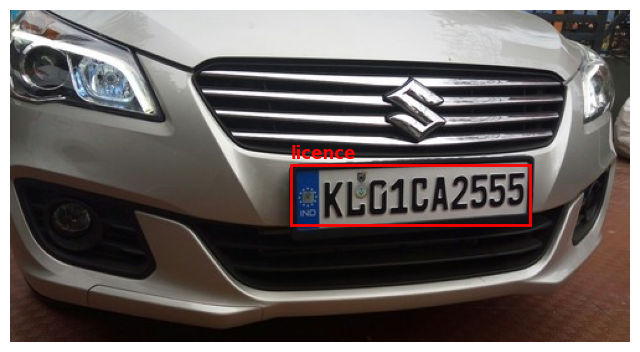

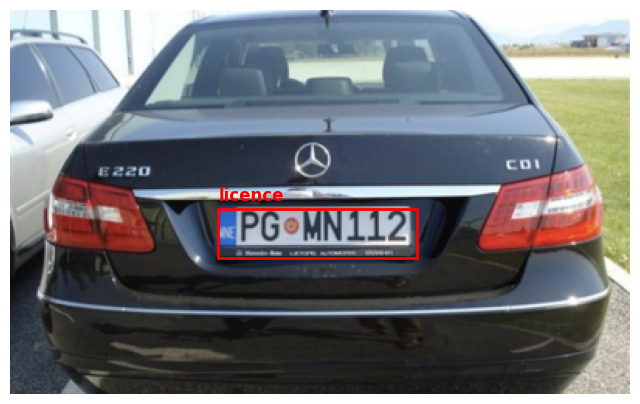

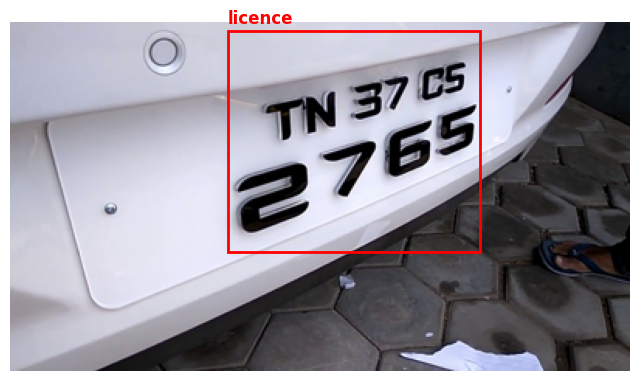

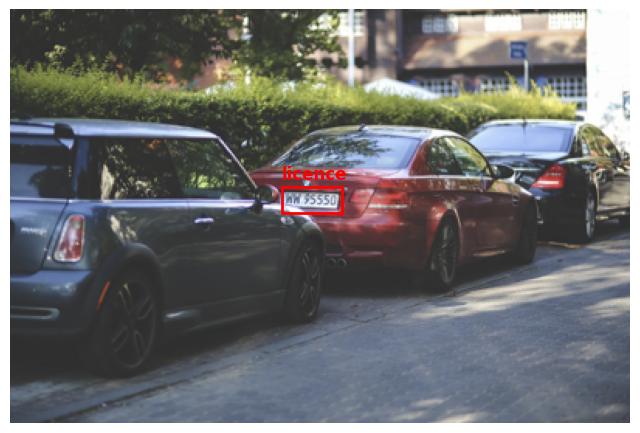

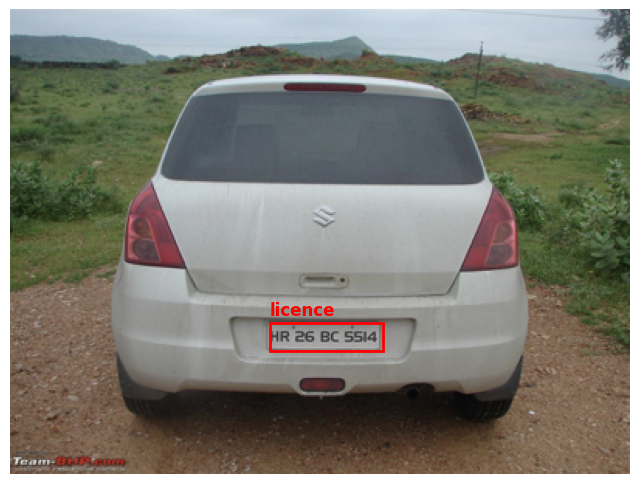

YOLO labels created and 5 images visualized!


In [7]:
# Visualize the first 5 images with bounding boxes
img_files = sorted(os.listdir(img_dir))[:5]
for img_file in img_files:
    img_path = os.path.join(img_dir, img_file)
    xml_path = os.path.join(annotations_dir, img_file.replace('.png', '.xml'))  # Adjust for JPG if needed
    if os.path.exists(xml_path):
        plot_image_with_bbox(img_path, xml_path)

print("YOLO labels created and 5 images visualized!")

In [8]:
# Get image and label file names
images = os.listdir(img_dir)
labels = os.listdir(labels_dir)

In [9]:
# Train-test split (80% train, 20% val)
train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

In [10]:
# Create folders
for folder in ['train', 'val']:
    os.makedirs(f'/kaggle/working/{folder}/images', exist_ok=True)
    os.makedirs(f'/kaggle/working/{folder}/labels', exist_ok=True)


In [11]:
# Move files to correct folders
for img in train_images:
    shutil.copy(os.path.join(img_dir, img), f'/kaggle/working/train/images/{img}')
    label = img.replace('.png', '.txt')  # Adjust this if images are jpg
    shutil.copy(os.path.join(labels_dir, label), f'/kaggle/working/train/labels/{label}')

for img in val_images:
    shutil.copy(os.path.join(img_dir, img), f'/kaggle/working/val/images/{img}')
    label = img.replace('.png', '.txt')
    shutil.copy(os.path.join(labels_dir, label), f'/kaggle/working/val/labels/{label}')
print("Data split into train/val sets!")



Data split into train/val sets!


# Clone the YOLOv10 Github Repo

In [12]:

!git clone https://github.com/THU-MIG/yolov10.git
%cd yolov10
     

fatal: destination path 'yolov10' already exists and is not an empty directory.
/kaggle/working/yolov10


###  Install All the Requried Packages

In [13]:
!pip install -q .


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Download the Pretrained Model Weights

In [14]:
weights_dir = os.path.join(os.getcwd(), 'weights')
os.makedirs(weights_dir, exist_ok = True)
#urls of the weights file
urls = ["https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt",
        "https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt",
        "https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt",
        "https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt",
        "https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt",
        "https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt"]

#Download each file
for url in urls:
  filename = os.path.basename(url)
  filepath = os.path.join(weights_dir, filename)
  urllib.request.urlretrieve(url, filepath)
  print(f"Downloaded: {filepath}")

Downloaded: /kaggle/working/yolov10/weights/yolov10n.pt
Downloaded: /kaggle/working/yolov10/weights/yolov10s.pt
Downloaded: /kaggle/working/yolov10/weights/yolov10m.pt
Downloaded: /kaggle/working/yolov10/weights/yolov10b.pt
Downloaded: /kaggle/working/yolov10/weights/yolov10l.pt
Downloaded: /kaggle/working/yolov10/weights/yolov10x.pt


In [15]:
data_yaml = """
train: /kaggle/working/train/images
val: /kaggle/working/val/images

nc: 1  # Number of classes (adjust to your dataset)
names: ['license_plate']  # Class names

"""

# Save data.yaml
yaml_path = "/kaggle/working/yolov10/data.yaml"
with open(yaml_path, "w") as f:
    f.write(data_yaml)

print(f"data.yaml created at {yaml_path}")

data.yaml created at /kaggle/working/yolov10/data.yaml


# Train Custom Model

In [16]:
os.environ['WANDB_MODE'] = 'disabled'


In [17]:
!pip uninstall ray -y


In [18]:
!yolo task=detect mode=train epochs=90 batch=16 plots=True model='weights/yolov10n.pt' data='/kaggle/working/yolov10/data.yaml'


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")
New https://py

# Examine Training Results

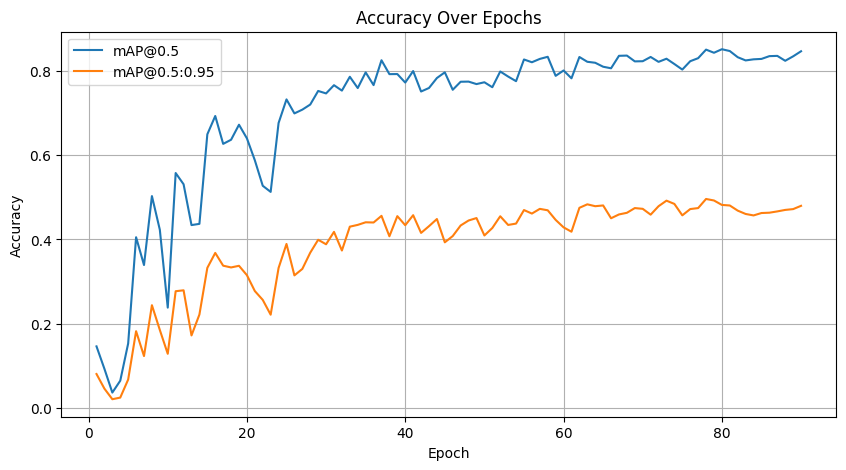

In [19]:
# Get the most recent training run directory
log_dirs = glob.glob('runs/detect/train*')


# Safely extract numbers and sort
def extract_train_number(path):
    digits = ''.join(filter(str.isdigit, path))
    return int(digits) if digits else 0

log_dirs.sort(key=extract_train_number)
log_dir = log_dirs[-1]

# Load the results.csv file
results_file = os.path.join(log_dir, 'results.csv')
if not os.path.exists(results_file):
    raise FileNotFoundError(f"No results.csv found in {log_dir}")

results = pd.read_csv(results_file)
results.columns = results.columns.str.strip()

# Extract accuracy metrics
epochs = results.index + 1
mAP_0_5 = results.get('metrics/mAP50(B)', None)
mAP_0_5_0_95 = results.get('metrics/mAP50-95(B)', None)

# Plot accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

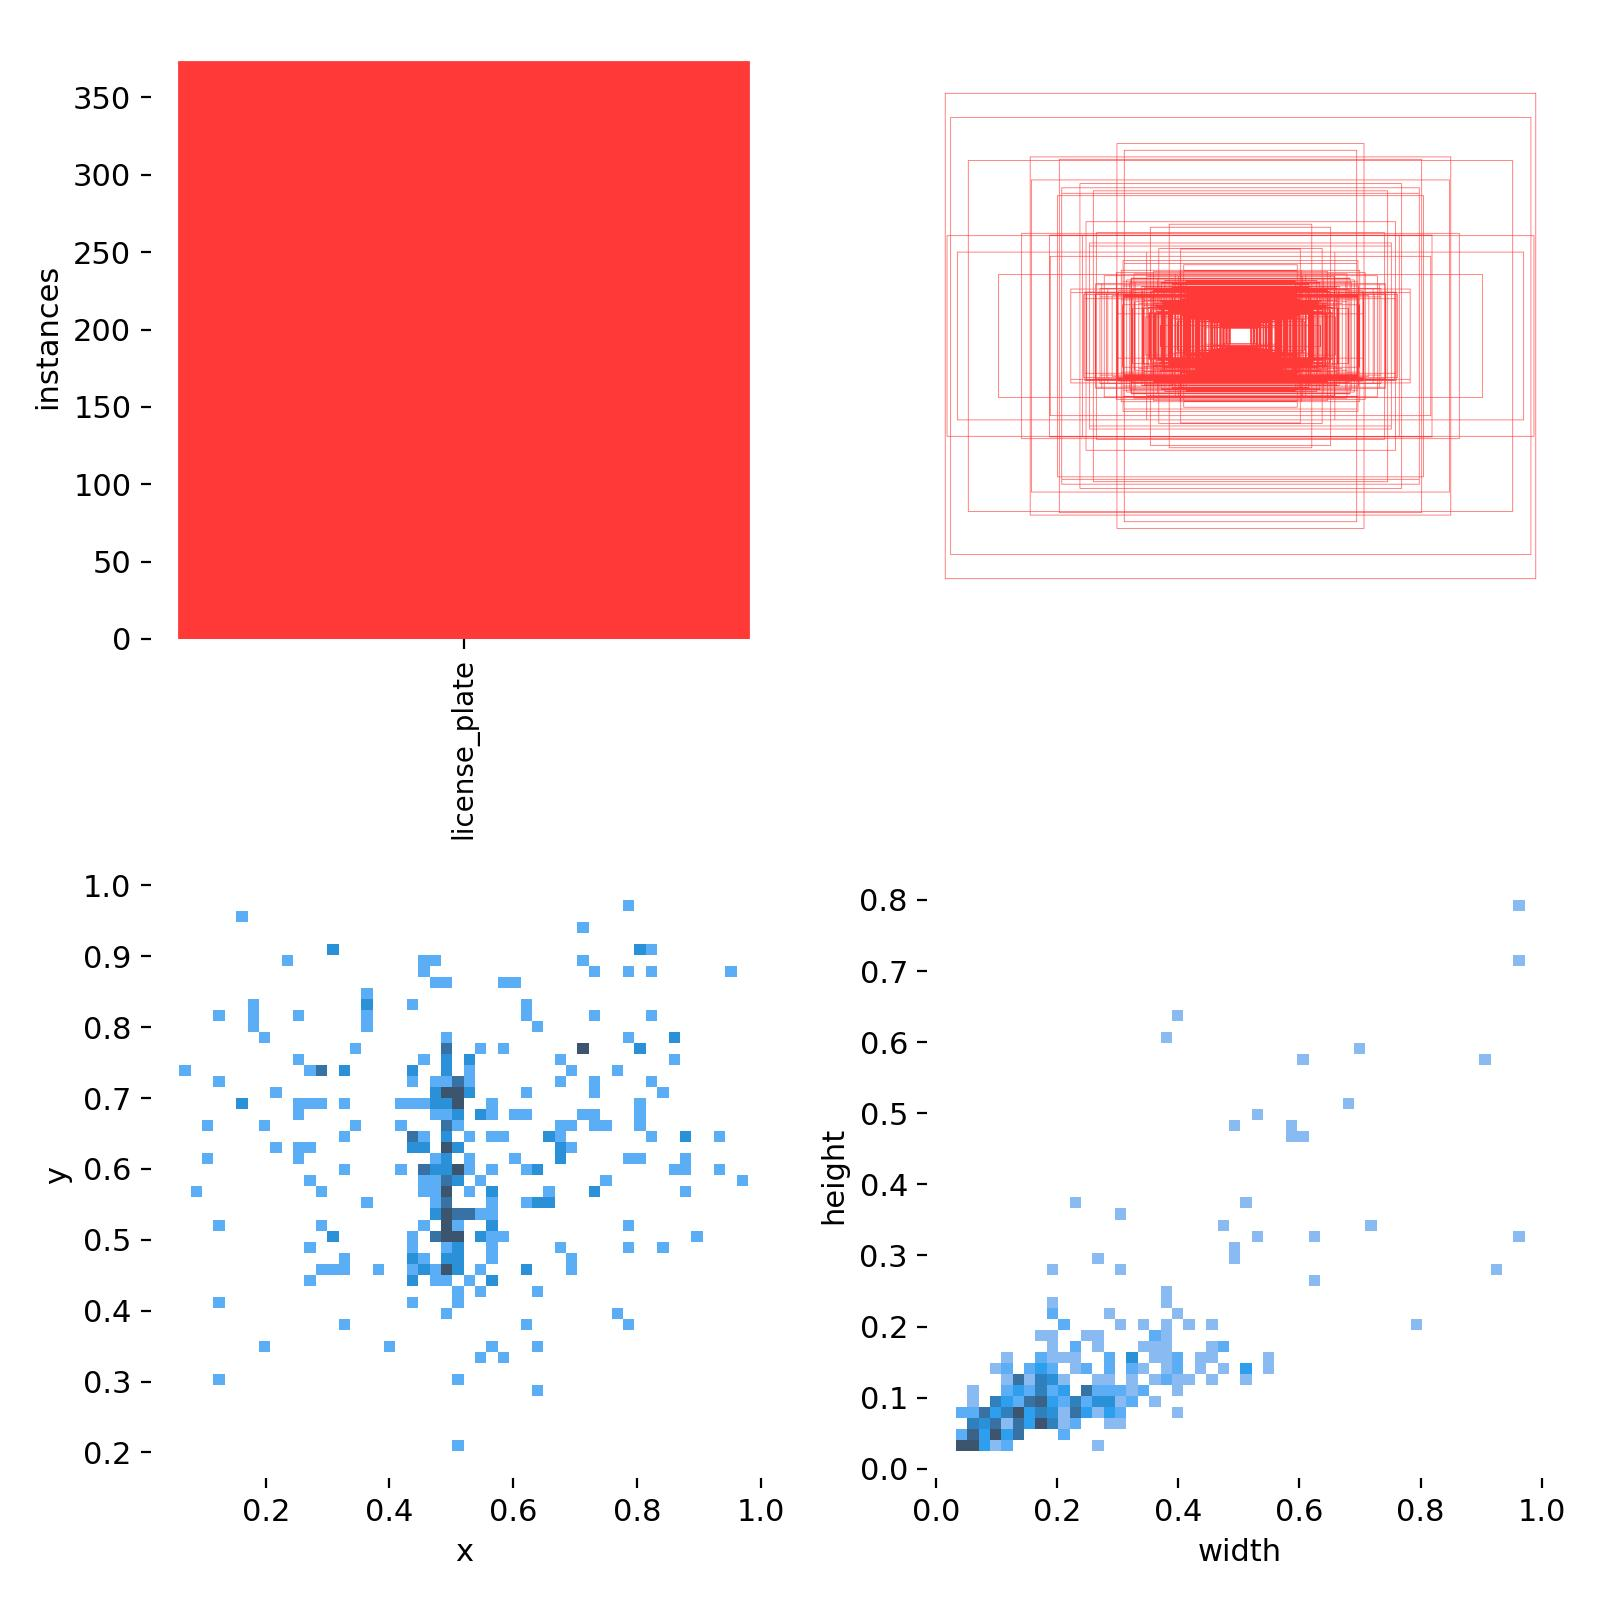

In [21]:
Image("/kaggle/working/yolov10/runs/detect/train2/labels.jpg")


**Top-left (Class distribution bar plot):**

It shows how many instances of each class are present.
there’s only one class — "license_plate" — with around 350 instances.

**Top-right (Bounding box visualization):**  

This plot overlays all bounding boxes from your dataset onto a single image.

**Bottom-left (Object center distribution — x vs. y):** 

A cluster in the middle might suggest most objects appear around the center of the images 

**Bottom-right (Bounding box dimensions — width vs. height):**

The tight cluster near the bottom-left implies most boxes are small, but some larger boxes stretch toward the top-right.


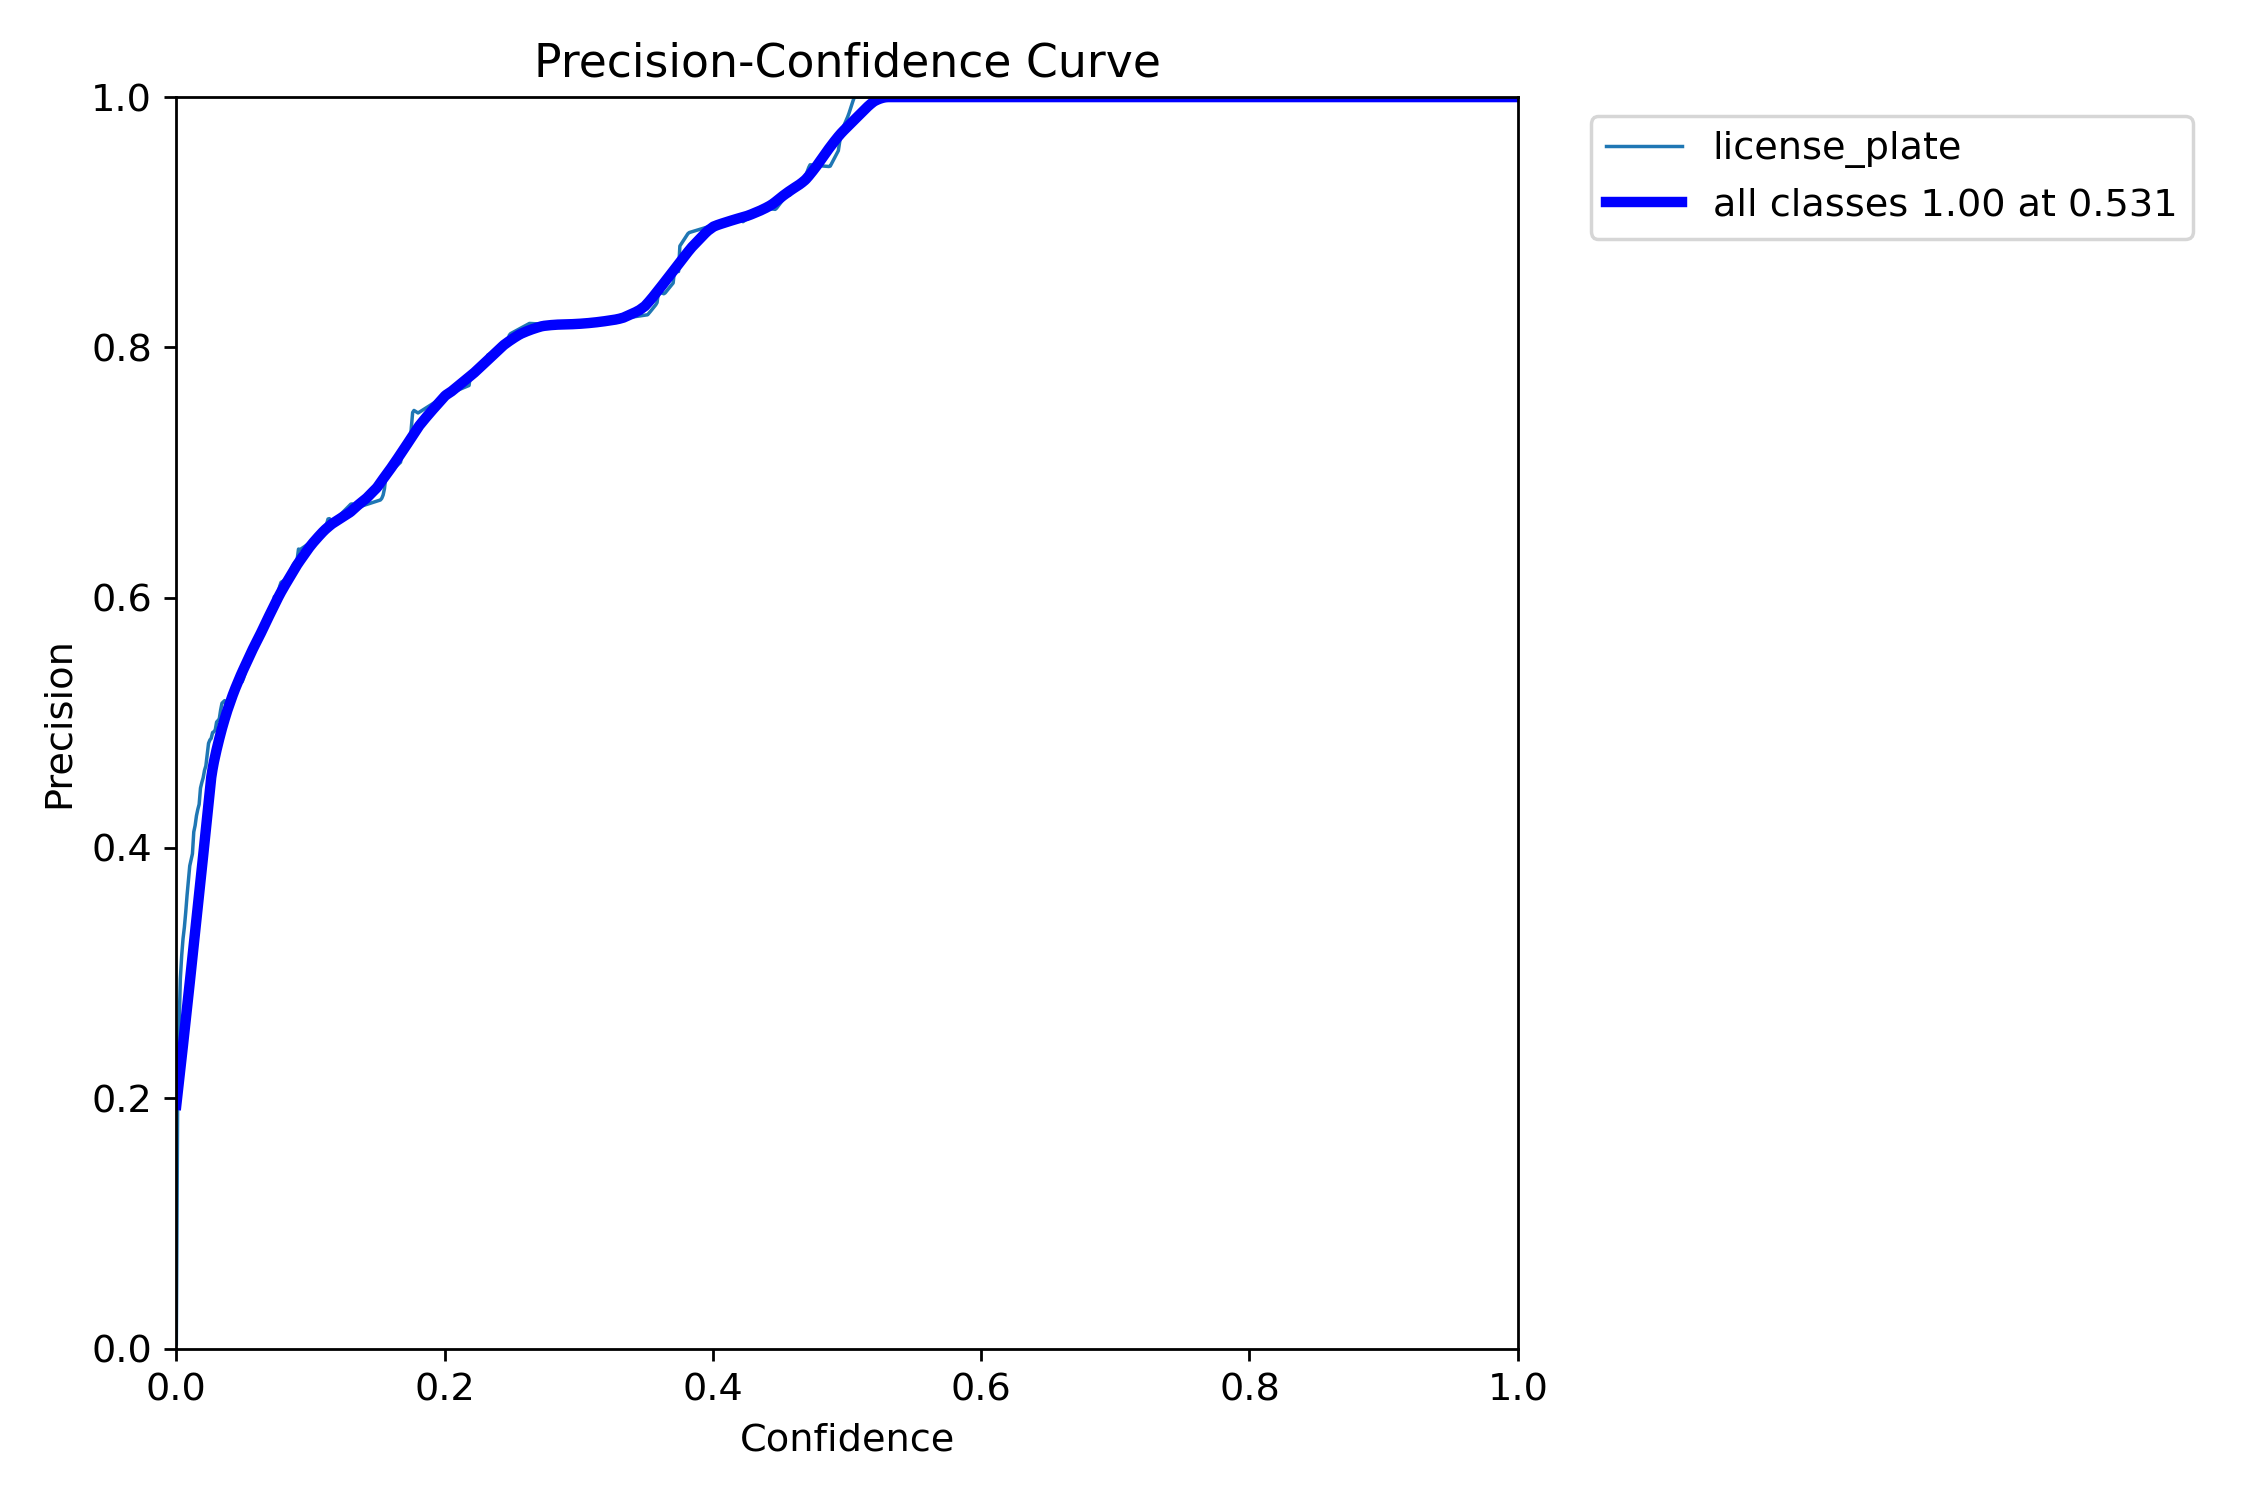

In [23]:
Image("/kaggle/working/yolov10/runs/detect/train2/P_curve.png")


The Precision-Confidence Curve shows how precision changes as the confidence threshold increases. At 0.53 confidence, precision reaches 1.00, indicating the model makes **no false positives** above this threshold.

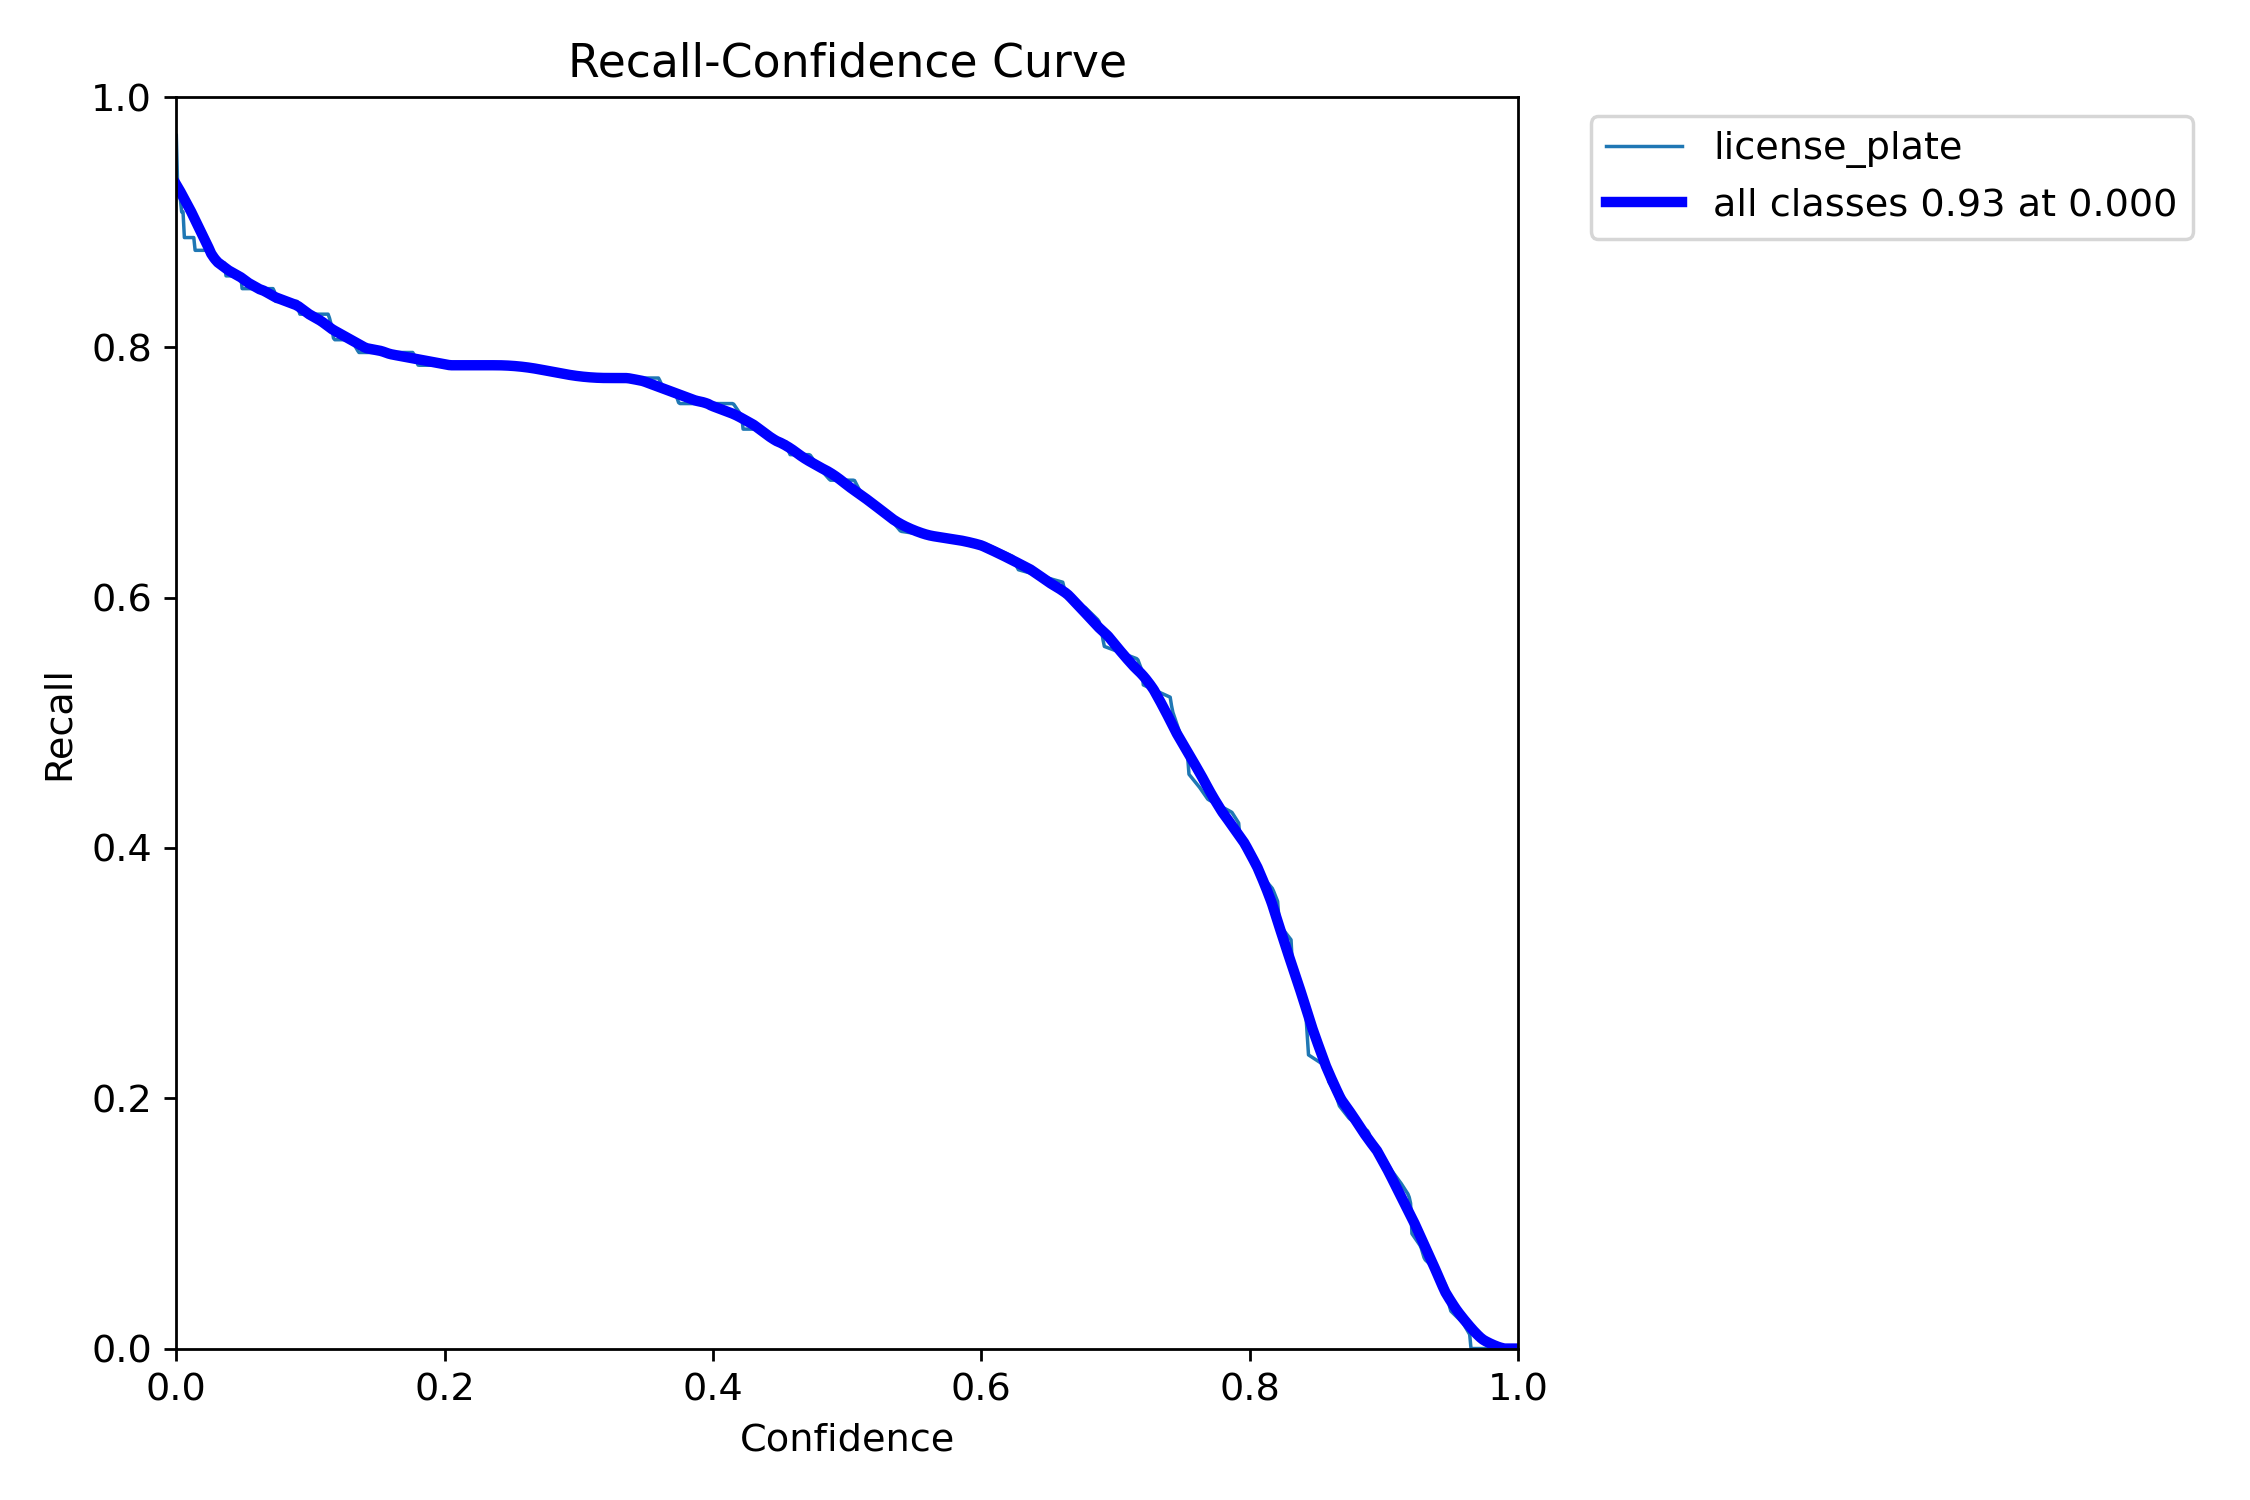

In [24]:
Image("/kaggle/working/yolov10/runs/detect/train2/R_curve.png")


The Recall-Confidence Curve shows how recall decreases as the confidence threshold increases — high recall at low confidence means more detections (including false positives), while higher confidence reduces detections, lowering recall. It helps balance catching all objects versus ensuring only confident detections are accepted.

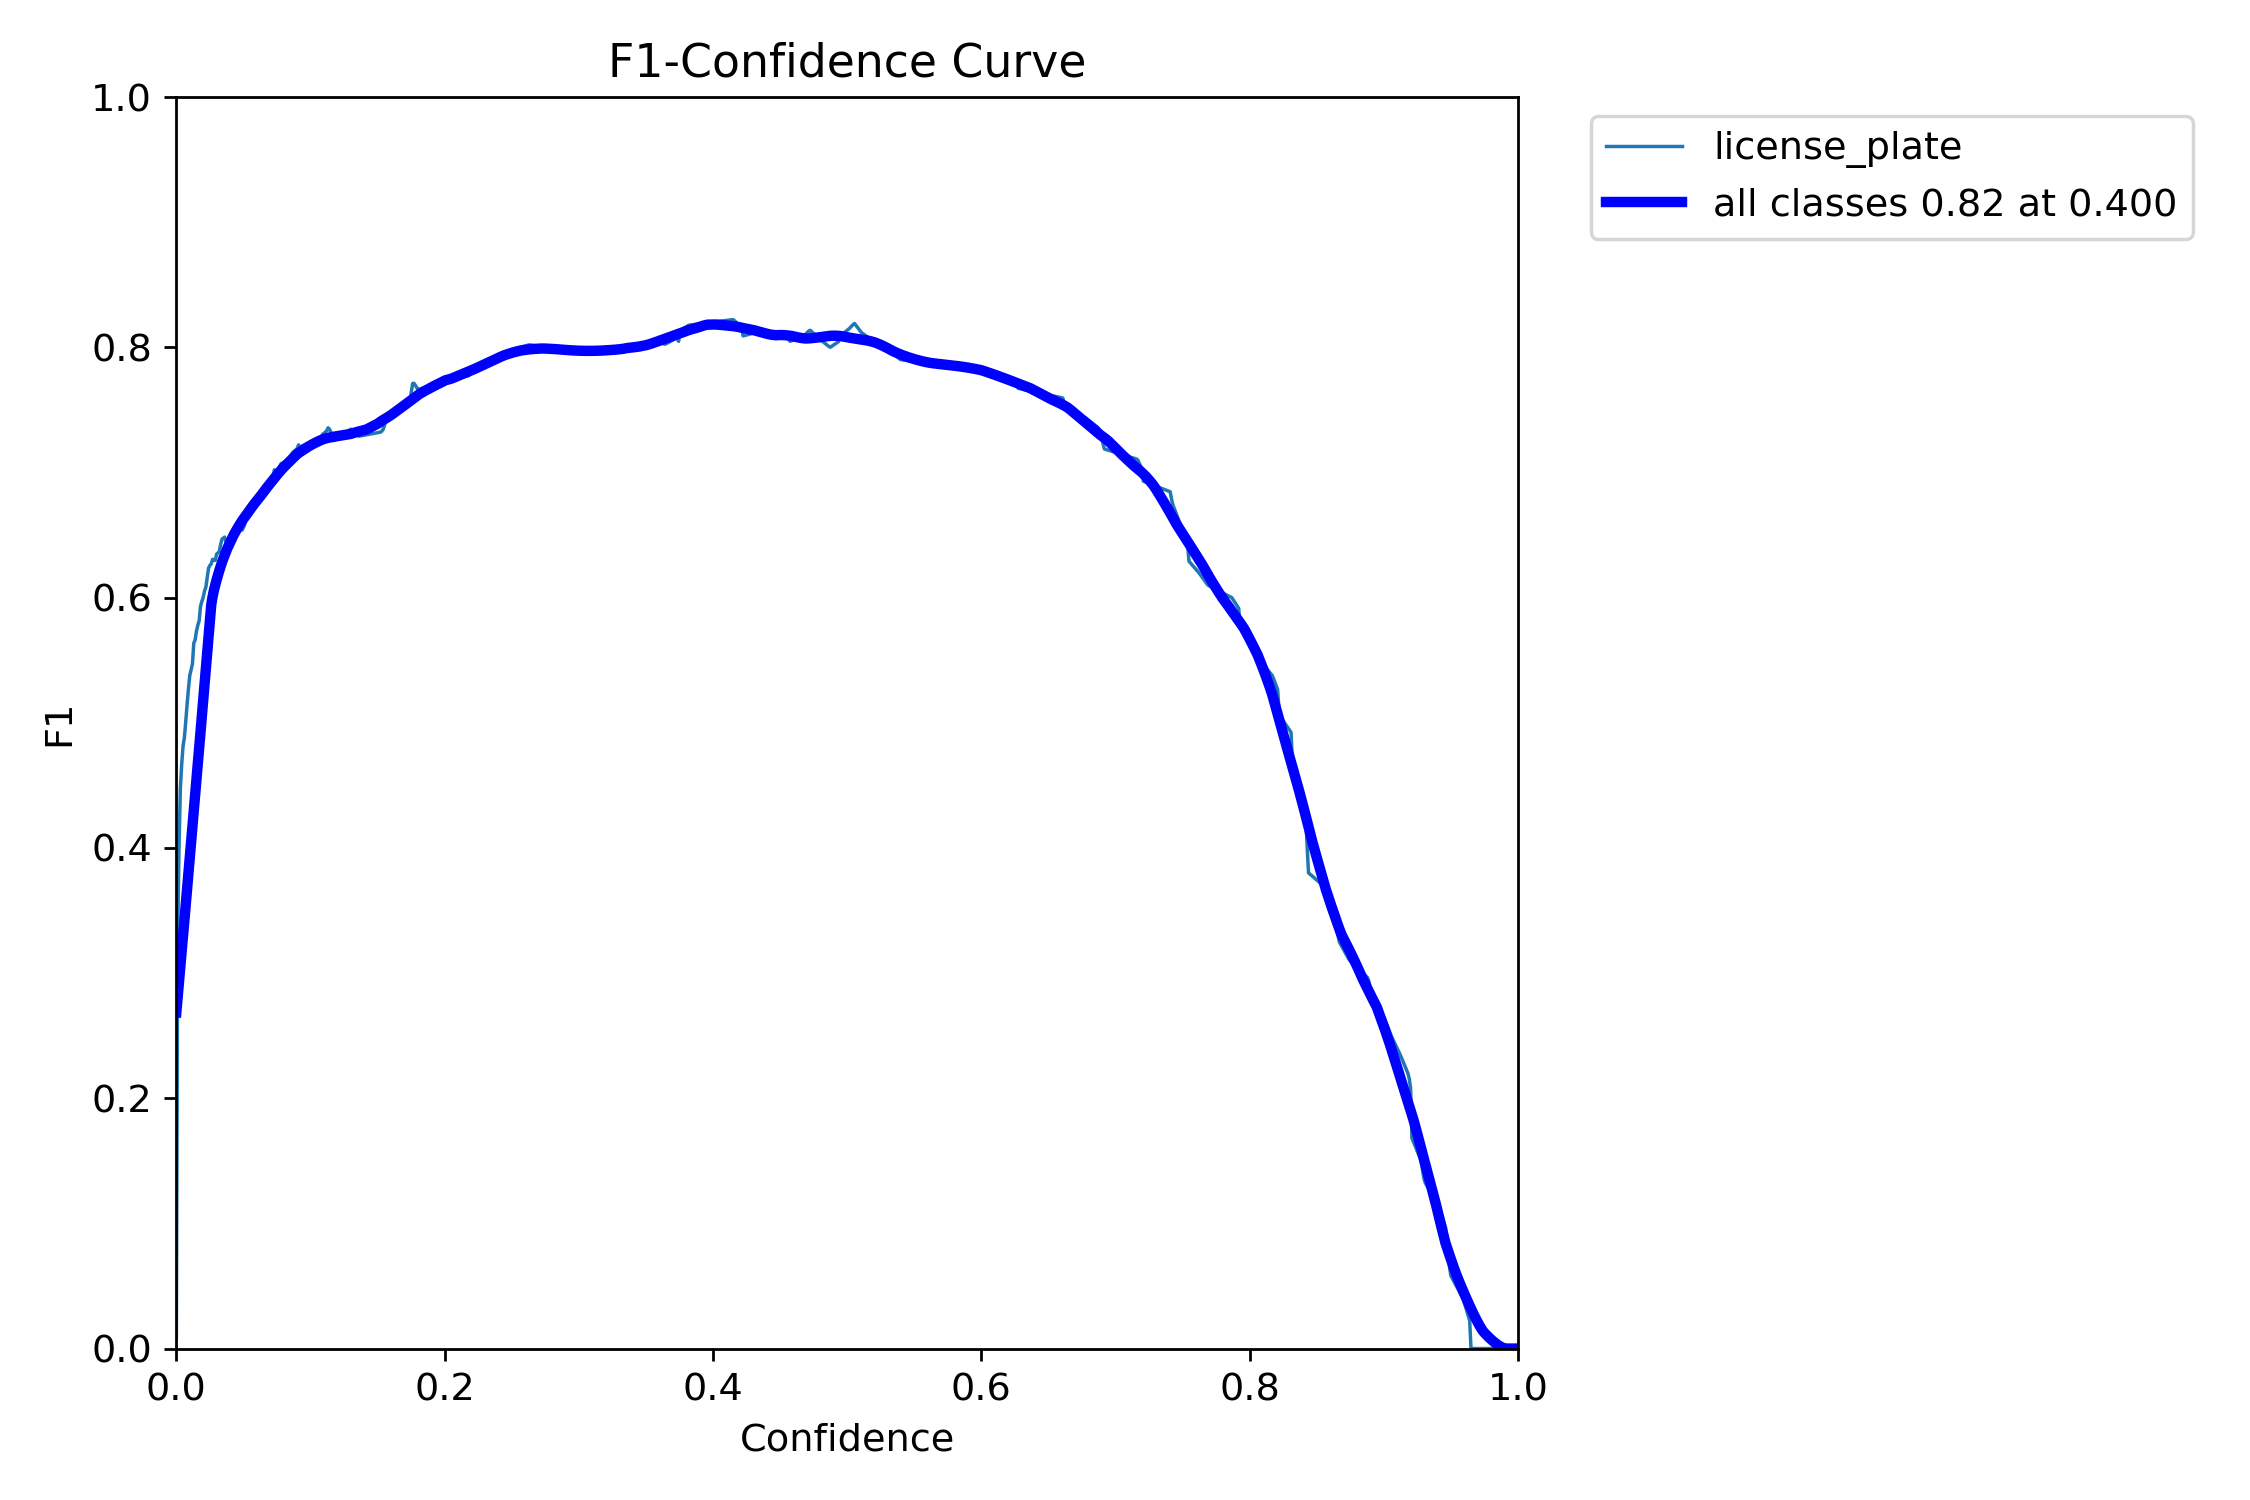

In [26]:
Image("/kaggle/working/yolov10/runs/detect/train2/F1_curve.png")


The F1-Confidence Curve shows how the F1 score (which balances precision and recall) changes with different confidence thresholds. The peak at 0.82 suggests the optimal balance occurs at a confidence level of 0.4.

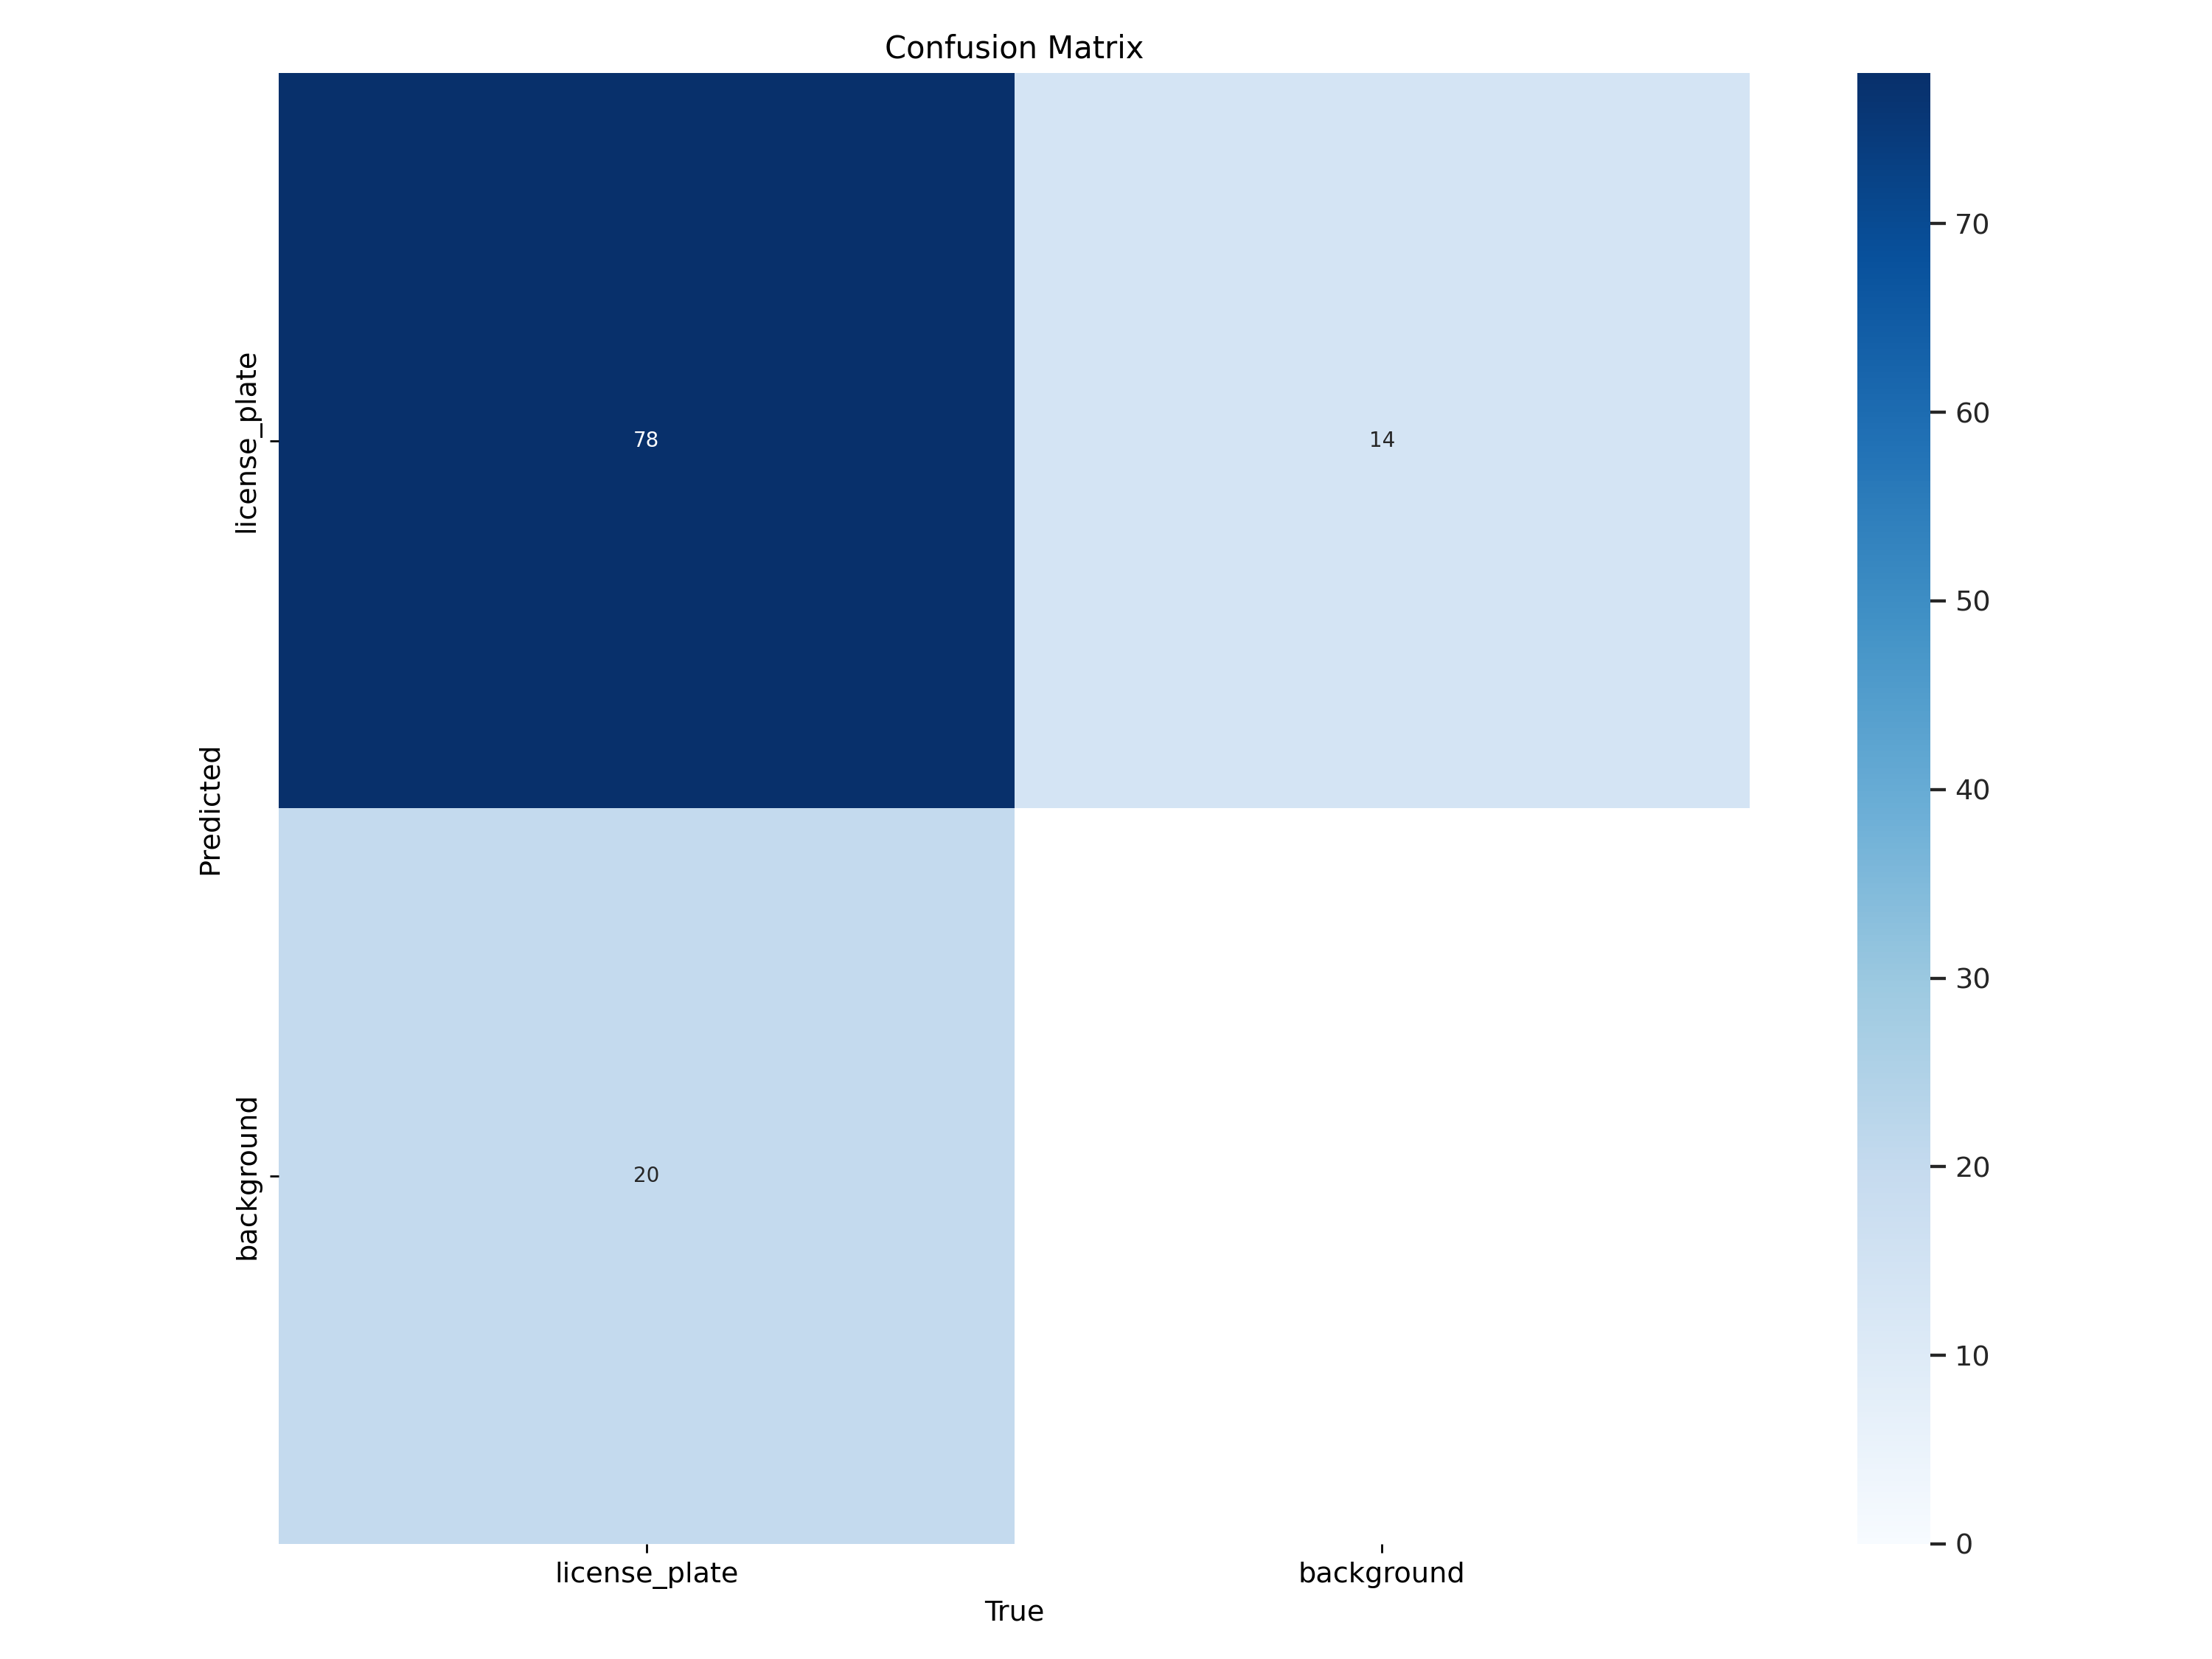

In [27]:
Image("/kaggle/working/yolov10/runs/detect/train2/confusion_matrix.png")


78 correct license plate detections (True Positives),   
14 background misclassified as license plates (False Positives),     
and 20 license plates missed (False Negatives).

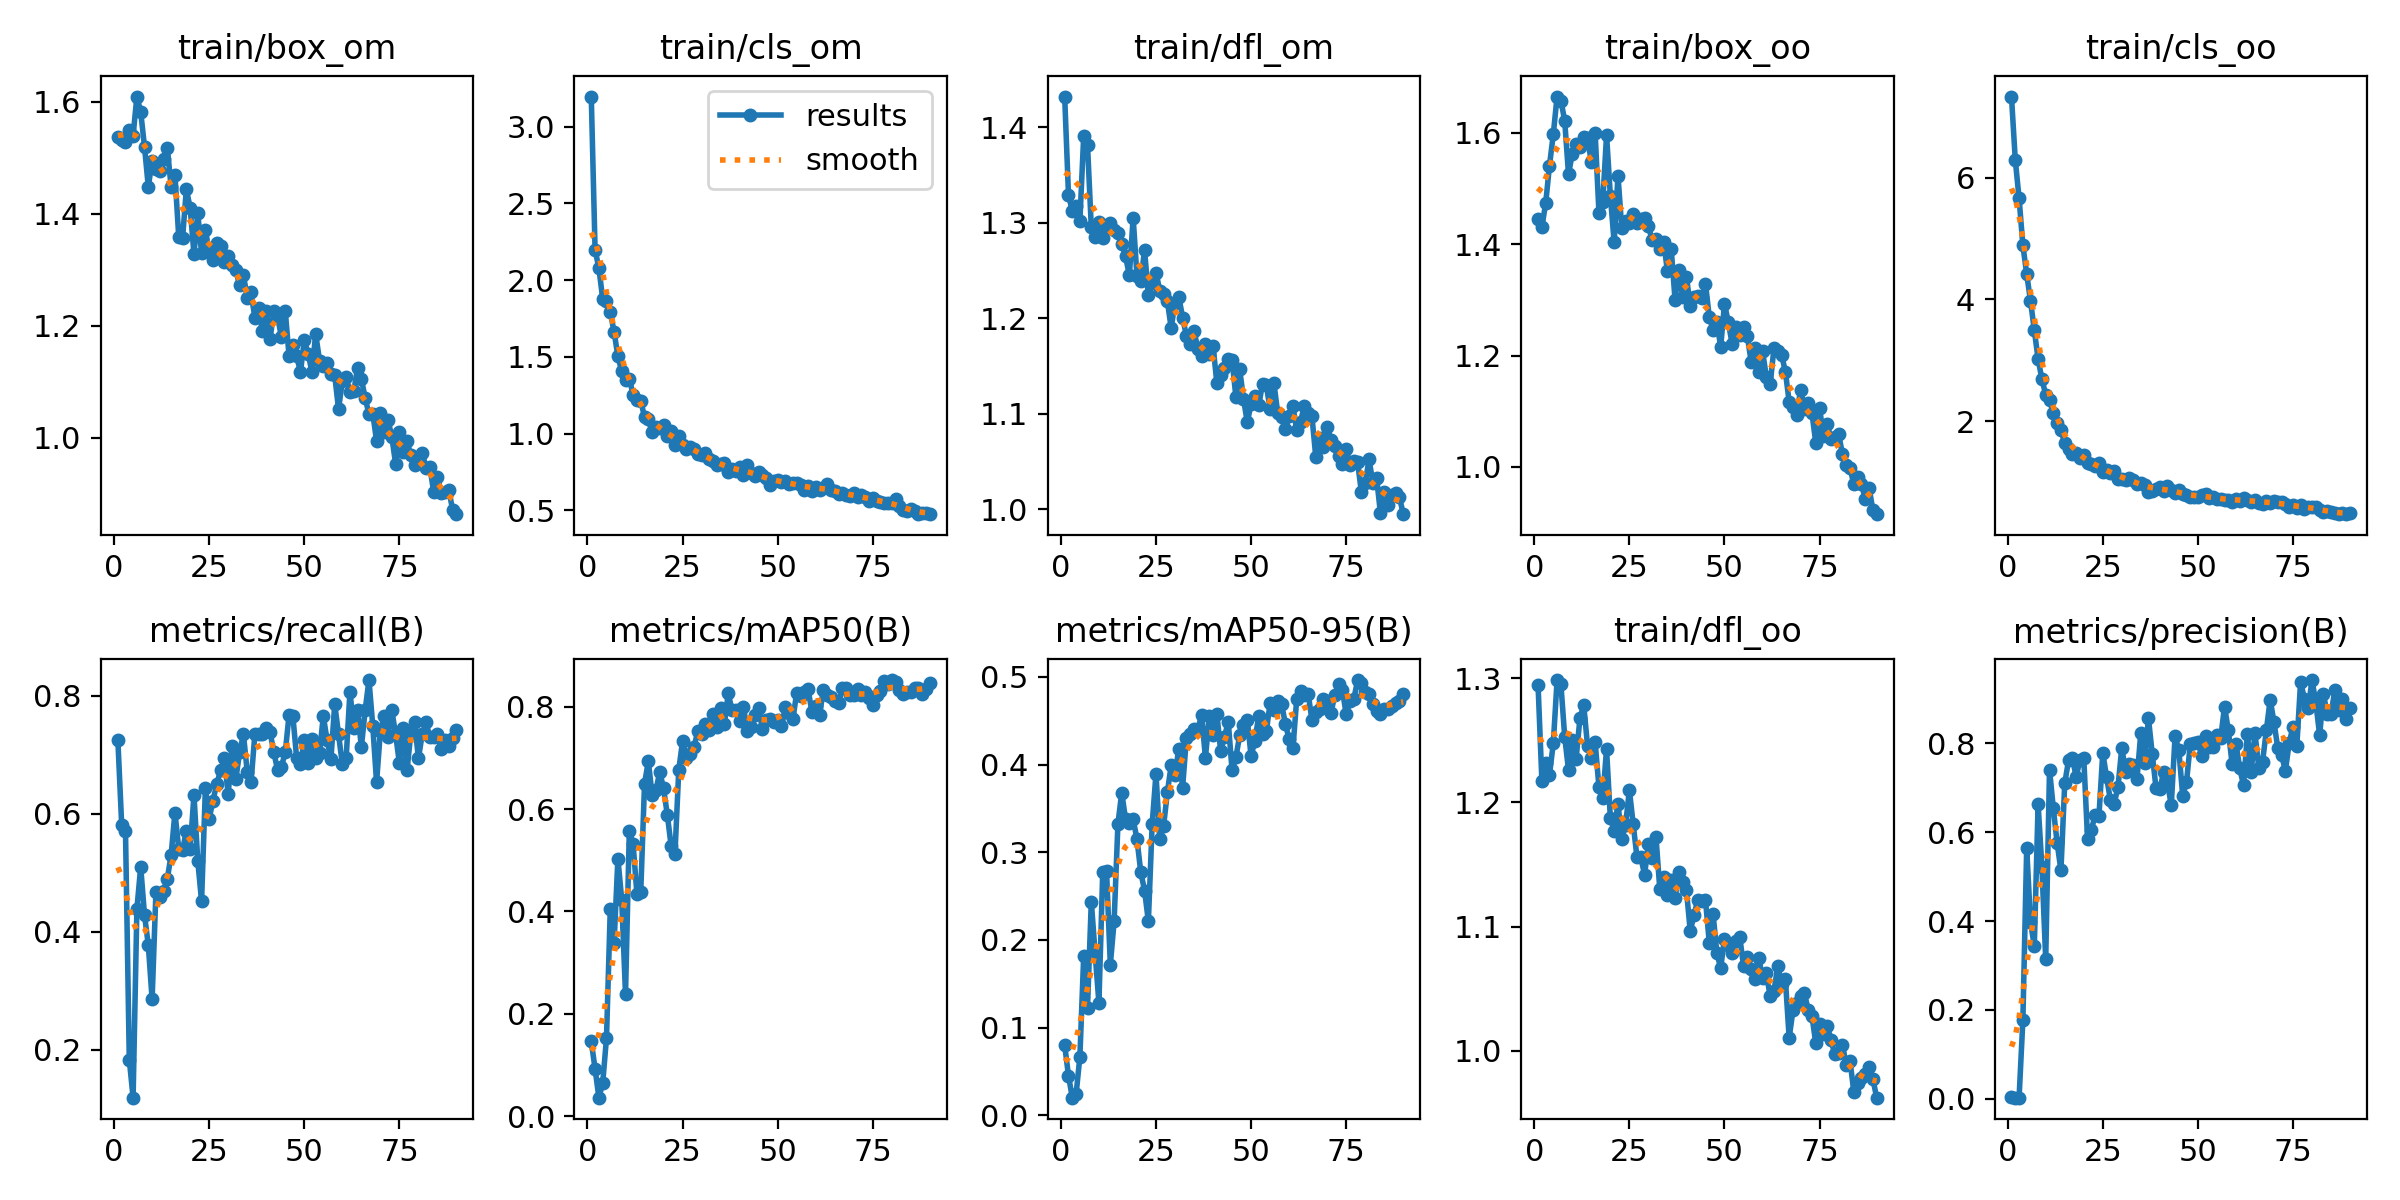

In [28]:
Image("/kaggle/working/yolov10/runs/detect/train2/results.png")


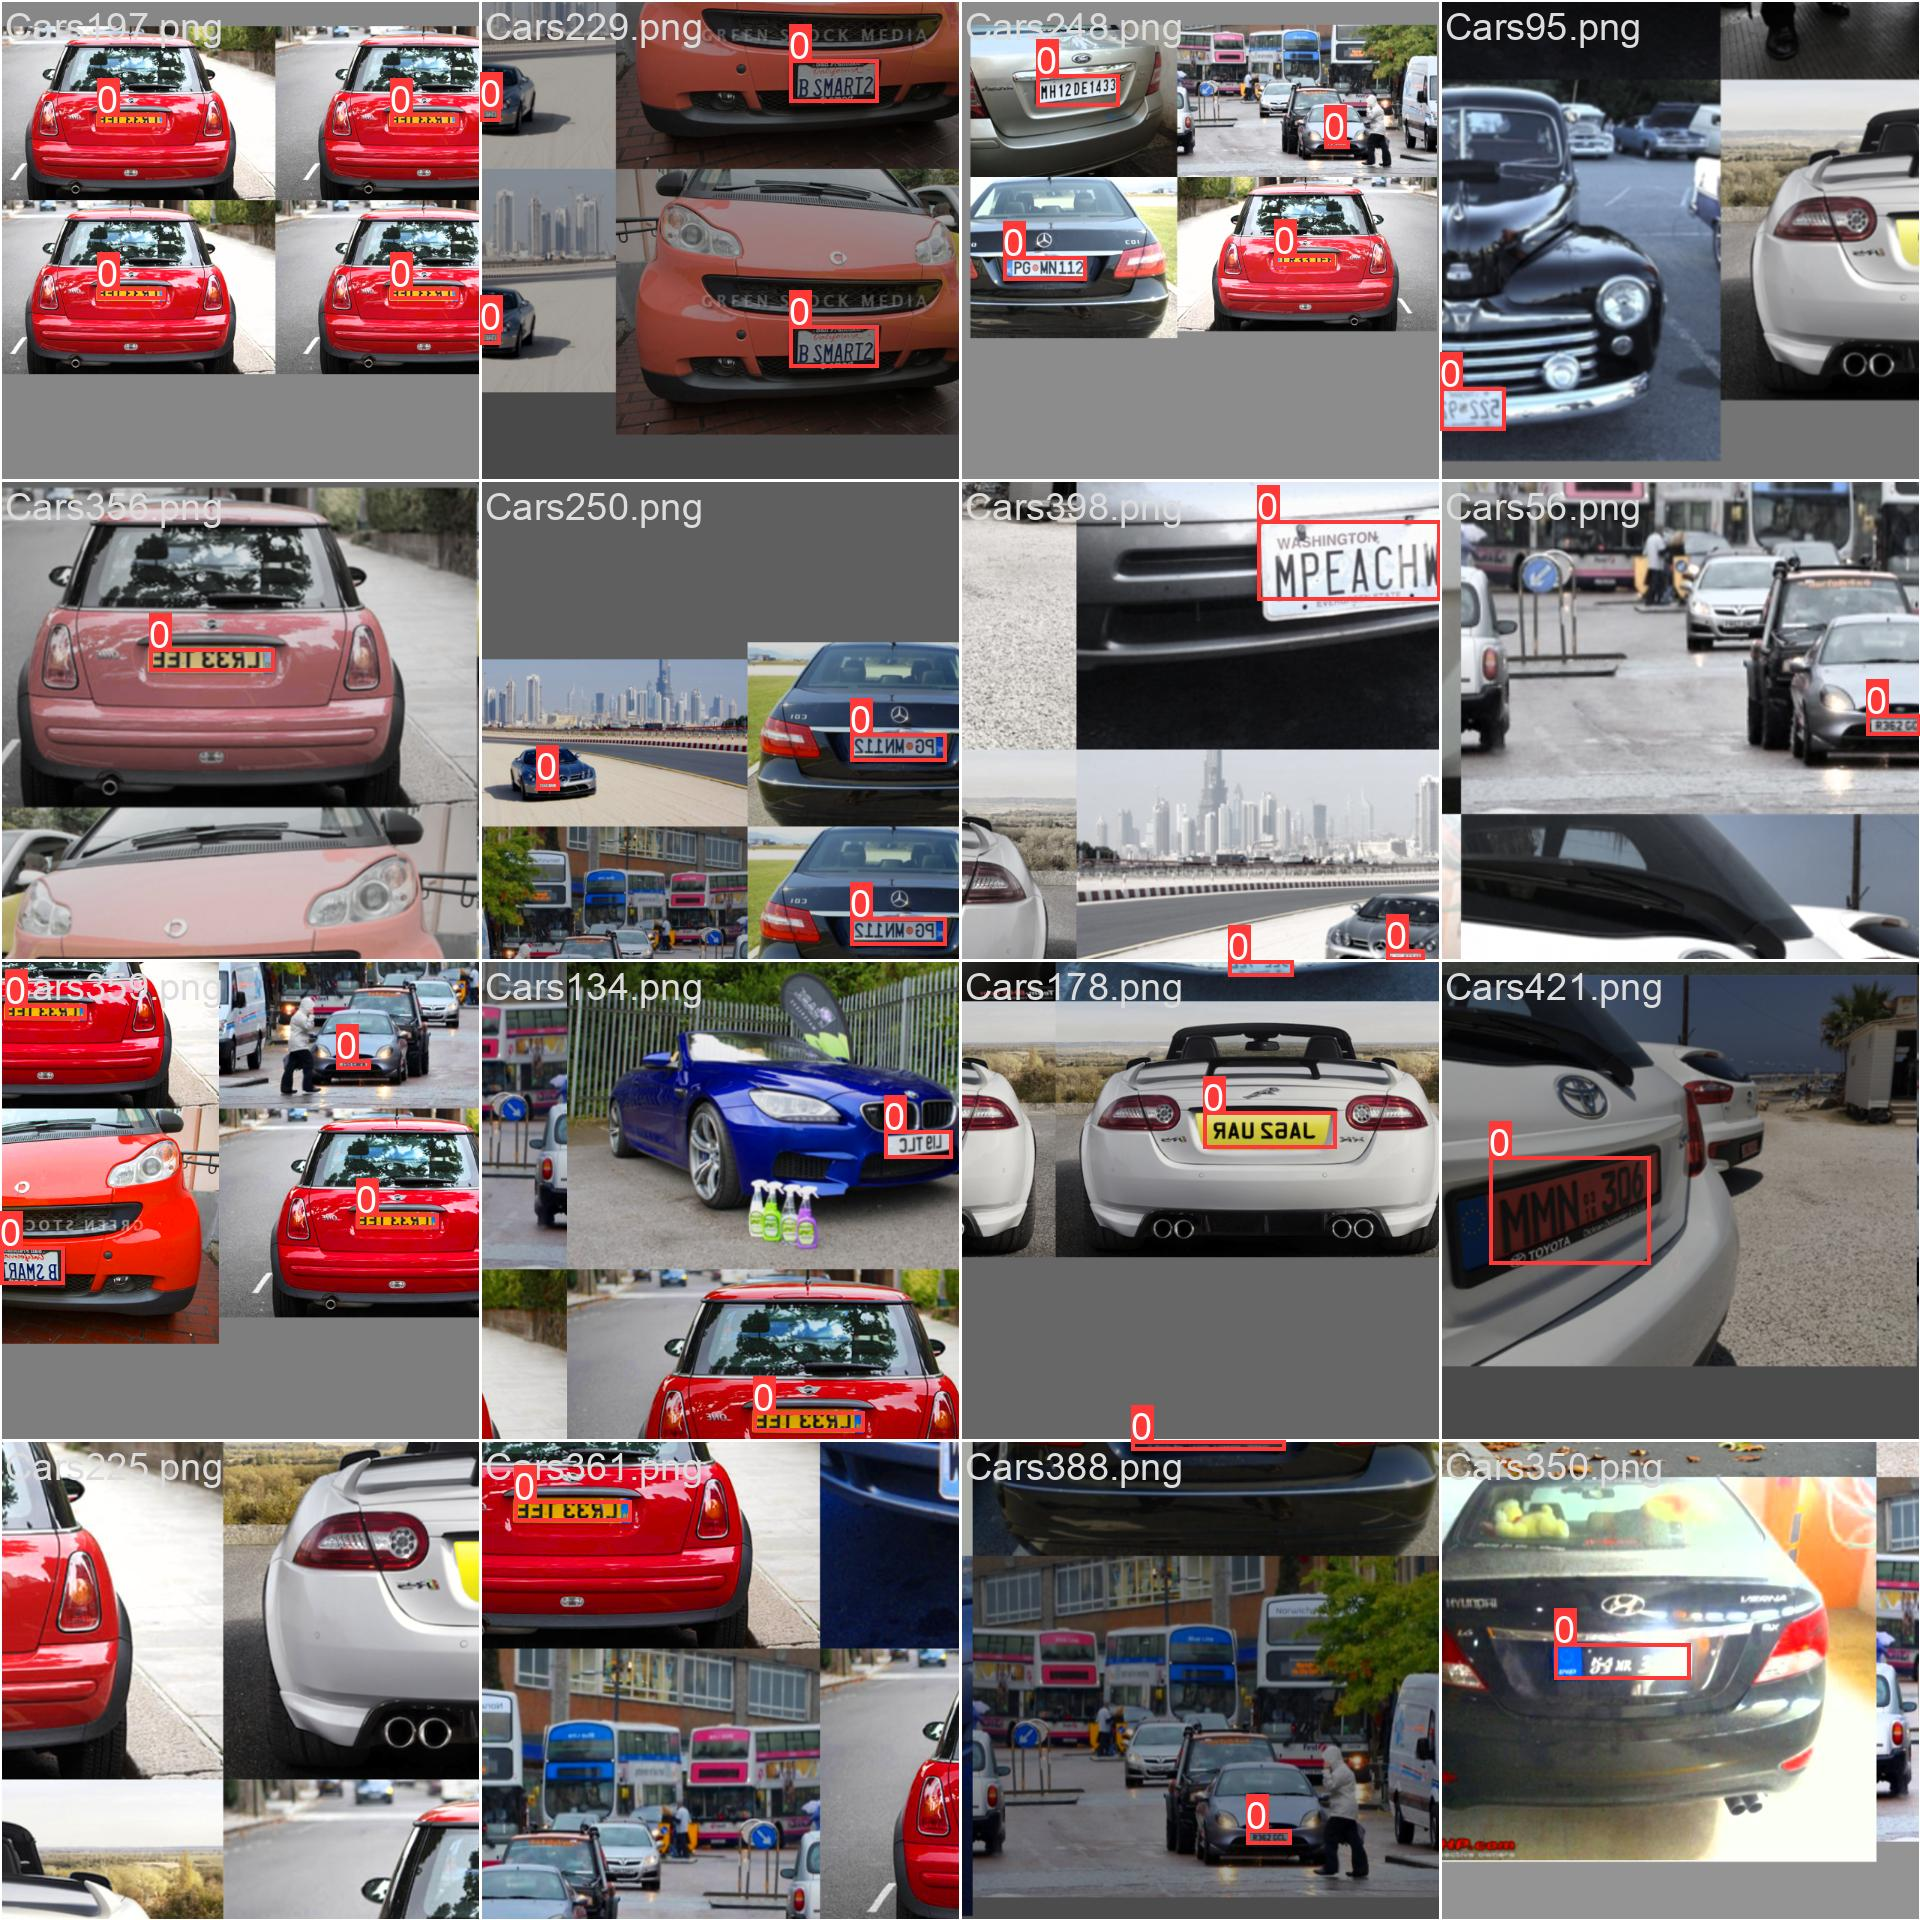

In [29]:
Image("/kaggle/working/yolov10/runs/detect/train2/train_batch0.jpg")


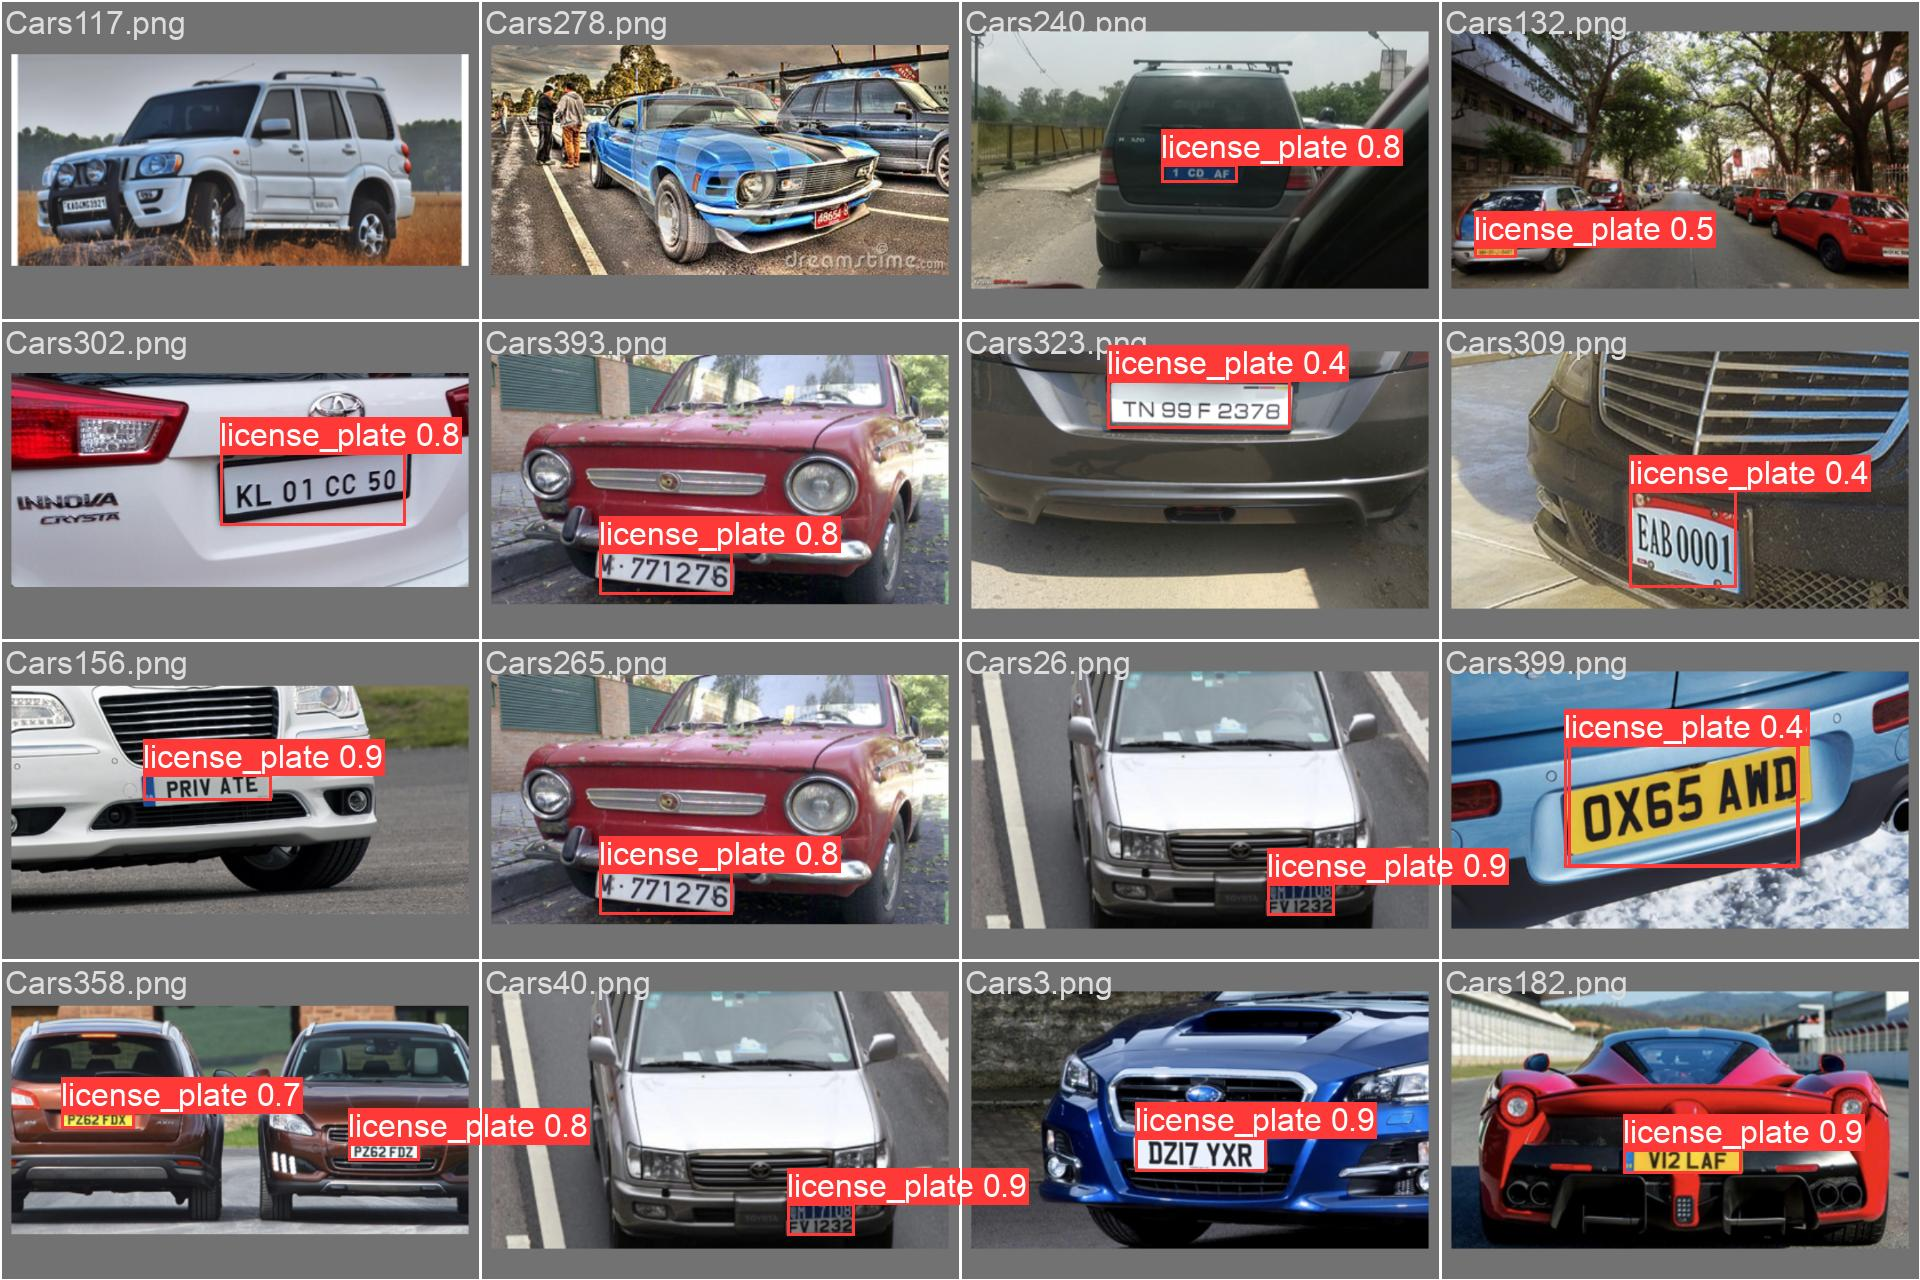

In [30]:
Image("/kaggle/working/yolov10/runs/detect/train2/val_batch0_pred.jpg")


# Test

## Images

In [35]:
!yolo task=detect mode=predict conf=0.25 save=True model='/kaggle/working/yolov10/runs/detect/train2/weights/best.pt' source='/kaggle/input/test-data/download (1).png'


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")
Ultralytics YO

In [36]:
!yolo task=detect mode=predict conf=0.25 save=True model='/kaggle/working/yolov10/runs/detect/train2/weights/best.pt' source='/kaggle/input/test-data/download.png'


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")
Ultralytics YO

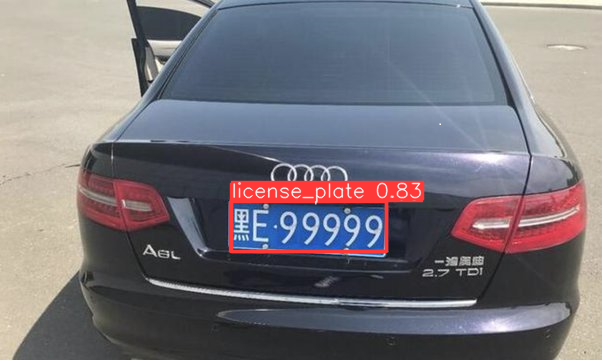

In [37]:
Image(filename='/kaggle/working/yolov10/runs/detect/predict/download.png')


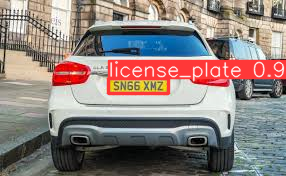

In [39]:
Image(filename='/kaggle/working/yolov10/runs/detect/predict2/download (1).png')


## Video

In [51]:
!yolo task=detect mode=predict conf=0.25 save=True model='/kaggle/working/yolov10/runs/detect/train2/weights/best.pt' source='/kaggle/input/test-data/mycarplate.mp4'


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")
Ultralytics YO

In [54]:

# Path to the saved prediction video
predicted_video = '/kaggle/working/yolov10/runs/detect/predict6/mycarplate.avi'

# Load the video
clip = VideoFileClip(predicted_video)

clip_resized = clip.resize(width=640)

# Display the resized video
clip_resized.ipython_display()


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


# Conclusion 

**Through this project, YOLOv10n demonstrated its effectiveness in real-time object detection, accurately identifying cars and license plates.**  

**Despite not achieving the highest accuracy compared to larger models, YOLOv10n was chosen for its lightweight architecture, making it ideal for resource-constrained environments.**  

**The model’s speed and efficiency highlight its potential for applications like autonomous driving and smart surveillance.**  

Future improvements could involve fine-tuning the model, expanding the dataset, or integrating the detection pipeline into a real-time system.**
